# Couette flows

Couette flows are driven by moving boundaries, like the surface of a car or a plane. We will consider two types of Couette flows, steady or unsteady, and start with the simpler steady flows.

## Steady Couette flows 

We will first look at a steady plane Couette flow, like in Chapter 3-2.1, where the height of the plane channel is $2h$. There is no applied pressure and no gravitational forces in the $x$-direction, so the Navier-Stokes equations reduce further to

```{math}
:label: eq:couettepde
\begin{aligned}
  \nabla ^2 u &= 0,    \\
  \frac{\partial u}{\partial x} &= 0,
\end{aligned}
```

with boundary conditions $u(-h)=0$ and $u(h)=U$ (see Fig. 3-1 in {cite}`white06`). The exact solution of these equations is

```{math}
:label: eq:exactCouette
 u(y) = \frac{U}{2}\left( 1 + \frac{y}{h} \right).
```

We will now solve the Couette flow numerically using [FEniCS](http://fenicsproject.org), which is a software used for solving differential equations with the finite element method. There is an excellent [tutorial](http://fenicsproject.org/documentation/tutorial) for quickly getting started with FEniCS.

FEniCS solves PDEs by expressing the original problem (the PDEs with boundary and initial conditions) as a variational problem. The core of the recipe for turning a PDE into a variational problem is to multiply the PDE by a function $v$, integrate the resulting equation over the computational domain (typically called $\Omega$), and perform integration by parts of terms with second-order derivatives. The function $v$ which multiplies the PDE is in the mathematical finite element literature called a test function. The unknown function $u$ to be approximated is referred to as a trial function. The terms test and trial function are used in FEniCS programs too.

In this course we will learn how to use the FEniCS software, but the focus will be on the physics of flow. We will use FEniCS to generate numerical solutions that we can easily play with to enhance our understanding of what the mathematical equations represent, but we will not go through the inner details of the finite element method.

In the current case of a Couette flow we will solve {eq}`eq:couettepde`. We assume here for completeness that the equation has an additional constant source $f$

$$
\nabla ^2 u = f.
$$

We now multiply the Poisson equation by the test function $v$ and integrate over the domain $\Omega=[-h, h]$,

$$
\int_\Omega (\nabla^2 u)v \, \mathrm{d}x = \int_\Omega fv \, \mathrm{d}x\thinspace .
$$

Note that $\mathrm{d}x$ is used to represent a volume integral. For Cartesian coordinates $\mathrm{d}x$ is equal to $\mathrm{d}x\mathrm{d}y\mathrm{d}z$, whereas for cylindrical coordinates it equals $r\mathrm{d}r\mathrm{d}\theta\mathrm{d}z$.

Next we apply integration by parts to the integrand on the left hand side with a second-order derivative,

```{math}
:label: eq:secondorderint
\int_\Omega (\nabla^2 u)v \, \mathrm{d}x =  -\int_\Omega\nabla u\cdot\nabla v \, \mathrm{d}x + \int_{\partial\Omega}{\partial u\over \partial n}v \, \mathrm{d}s ,
```

where $\partial u \over \partial n$ is the derivative of u in the outward normal direction at the boundary (here at $y=\pm h$). The test function $v$ is required to vanish on the parts of the boundary where $u$ is known, which in the present problem implies that $v=0$ for $y=\pm h$. The second term on the right-hand side of {eq}`eq:secondorderint` therefore vanishes for the current problem and we are left with

$$
-\int_\Omega \nabla u \cdot \nabla v \, \mathrm{d}x = \int_\Omega fv \, \mathrm{d}x\thinspace ,
$$

which is also referred to as the weak form of the original boundary value problem ($\nabla^2 u=f$ with boundary conditions). The finite element method discretizes and solves this weak form of the problem on a domain divided into non-overlapping cells. In 2D we typically apply triangles, whereas in 3D tetrahedrons are applied. For 1D problems like the Couette flow we simply divide the computational domain $\Omega$ into non-overlapping intervals.

The final step required for building a finite element solution is to choose an appropriate function space for our solution. A function space can for example be piecewise linear functions or piecewise polynomials of a higher degree. Different function spaces can be chosen for the trial and test functions, but in general they only differ on the boundaries.
The test and trial spaces $\hat{V}$ and $V$ are in the present problem defined as

```{math}
:label: eq:TestSpace
\hat{V} = \{v \in H^1(\Omega) : v = 0 \text{ for } y=\pm h\},
```

```{math}
:label: eq:TrialSpace
V = \{v \in H^1(\Omega) : v = 0 \text{ for } y=-h \text{ and } v=U for y=h\},
```

Briefly, $H^1(\Omega)$ is known as the Sobolev space containing functions $v$ such that $v^2$ and $\|\nabla v\|^2$ have finite integrals over $\Omega$. You will learn more about the Sobolev space in a basic finite element course. For now it will be sufficient to know that you need to choose a function space and for fluid flow it is usually appropriate to choose a space consisting of piecewise linear or quadratic polynomials.

Note that the proper mathematical statement of our variational problem now goes as follows: Find $u \in V$ such that

```{math}
:label: eq:varCouette
-\int_{\Omega} \nabla u \cdot \nabla v \, \mathrm{d}x = \int_{\Omega} fv \, \mathrm{d}x \quad \forall v \in \hat{V}.
```

(implementation-couette)=
### Implementation

The entire implementation that solves the variational problem {eq}`eq:varCouette` is given below:

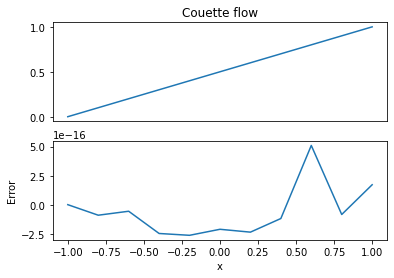

In [1]:
"""
Couette flow
"""
from dolfin import *
import matplotlib.pyplot as plt
%matplotlib inline

h = 1.
N = 10
mesh = IntervalMesh(N, -h, h)
V = FunctionSpace(mesh, 'CG', 1)
u = TrialFunction(V)
v = TestFunction(V)

def bottom(x, on_boundary):
    return near(x[0], -h) and on_boundary

def top(x, on_boundary):
    return near(x[0], h) and on_boundary

U = 1.
bcs = [DirichletBC(V, 0, bottom),
       DirichletBC(V, U, top)]

u_ = Function(V)
solve(-inner(grad(u), grad(v))*dx == Constant(0)*v*dx, u_, bcs=bcs)

u_exact = project(Expression("U/2*(1+x[0]/h)", U=U, h=h, degree=1), V)

plt.subplot(211)
plot(u_, title="Couette flow")
plt.xticks([])
plt.subplot(212)
plot(u_ - u_exact)
plt.ylabel('Error')
plt.xlabel('x')
plt.show()

A more thorough tutorial for the Poisson equation is given in [the online tutorial](https://fenicsproject.org/docs/dolfin/dev/python/demos/poisson/demo_poisson.py.html). Here we will repeat only the most necessary steps. The first thing we need to do is to import all basic FEniCS functionality into the python environment


```python
from dolfin import *
```

This is typically the first line of most FEniCS scripts as it imports all necessary functionality like `Interval, FunctionSpace, Function, DirichletBC, UnitSquare` and much, much more. A computational mesh is then generated by dividing the computational domain ($\Omega = [-h, h]$) into N equally sized intervals, each of size $2h/\mathrm{N}$


```python
h = 1.
N = 10
mesh = IntervalMesh(N, -h, h)
```

We now choose a piecewise linear solution by defining a function space over the mesh


```python
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
```

Second order polynomials or higher may be chosen by using a higher number here, but for the current problem this will not enhance the accuracy since the analytical solution is linear. The trial and test functions $u$ and $v$ are then declared, just as described leading up to {eq}`eq:varCouette`.

The current problem assigns a value for $u$ on both boundaries, which is mathematically termed Dirichlet boundary conditions. To implement these Dirichlet conditions we first need to specify where the boundaries are using two python functions


```python
def bottom(x, on_boundary):
    return near(x[0], -h) and on_boundary

def top(x, on_boundary):
    return near(x[0], h) and on_boundary
```

Here x is an array representing position. It is an array of length equal to the number of spatial dimensions of the mesh. In our case it is an array of length 1. The boundary conditions are created using the FEniCS function `DirichletBC`.


```python
U = 1.
bcs = [DirichletBC(V, 0, bottom),
       DirichletBC(V, U, top)]
```

Note that by using brackets $[\,]$ the two boundary conditions are placed in a python list named bcs. The variational problem is solved by creating a `Function` to hold the solution and then calling the function `solve`.


```python
u_ = Function(V)
solve(-inner(grad(u), grad(v))*dx == Constant(0)*v*dx, u_, bcs=bcs)
```

The $u_{-}$ `Function` has $\mathrm{N}+1$ unknowns, which are the solutions at the $\mathrm{N}+1$ nodes of the mesh. However, it is important to remember that the finite element solution is not restricted to the nodes of the mesh. The finite element solution is the piecewise continuous linear profiles, well defined over the entire elements. You can look at the discrete solution at the nodes on the command line as a numpy array using

In [2]:
w = u_.vector().get_local()
print(w)

[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0. ]


We can put the exact solution in a FEniCS `Function` by projecting a known analytical solution as an `Expression` onto the same function space as the numerical solution:

```python
u_exact = project(Expression("U/2*(1+x[0]/h)", U=U, h=h), V)
```

The `Function` `u_exact` will now contain $\mathrm{N}+1$ values, just like `u_`, and if we have computed correctly these values should be more or less the same as in `u_`. The plot above of the numerical solution minus the exact solution (`plot(u_ - u_exact, title="Error couette flow")`) shows that the computed solution is exact down to machine precision $\approx 10^{-16}$. This is to be expected since the solution is linear and we are assuming a piecewise linear finite element solution.

### Flow between axially moving concentric cylinders

The next steady example in Chapter 3-2.2 is the flow between axially moving concentric cylinders. The equation is the same as for the regular Couette flow in 3-2.1, but the coordinate system is cylindrical.
There is no applied pressure gradient and the flow is described by the Poisson equation with no source.

```{math}
:label: eq:poissonCyl
\begin{aligned}
  \nabla^2 u &= 0, \\
  \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial u}{\partial r} \right) &= 0. 
\end{aligned}
```

The two cylinders have diameters $r_0$ and $r_1$, where $r_0<r_1$. The Dirichlet boundary conditions are $u(r=r_0)=u_0$ and $u(r=r_1)=u_1$. The solution to {eq}`eq:poissonCyl` can be found by integrating twice

```{math}
:label: eq:ustep1
  u(r) = C_1 \ln(r) + C_2,
```

where the two integration constants are found using the boundary conditions leading to

$$
\begin{aligned}
 C_1 &= \frac{U_1-U_0}{\ln(r_1/r_0)} \\
 C_2 &= U_0\frac{\ln(r_1)}{\ln(r_1/r_0)} - U_1 \frac{\ln(r_0)}{\ln(r_1/r_0)}
\end{aligned}
$$

which inserted into {eq}`eq:ustep1` gives

```{math}
:label: eq:UaxCyl
 u(r) = U_0\frac{\ln(r_1/r)}{\ln(r_1/r_0)} + U_1\frac{\ln(r/r_0)}{\ln(r_1/r_0)}.
```

Eq. {eq}`eq:UaxCyl` is exactly the sum of Eqs.~(3-18) and (3-19), which is a result of the governing equation being linear.

The variational formulation of the problem reads

$$
-\int_\Omega \nabla u \cdot \nabla v \, \mathrm{d}x = \int_\Omega fv \, \mathrm{d}x\thinspace ,
$$

but in Cylindrical coordinates the volume integral needs to be transformed ($\mathrm{d}x = r\mathrm{d}r2\pi L$, assuming the cylinder has length $L$) and the variational problem becomes

$$
-\int_\Omega \nabla u \cdot \nabla v \, r \mathrm{d}r = \int_\Omega fv r \, \mathrm{d}r\thinspace.
$$

Note that the gradient requires no special treatment since the gradient component in the $r$-direction is unchanged in cylindrical coordinates.

A FEniCS implementation for axially moving concentric cylinders is shown below.


Error  2.7838640479591485e-05


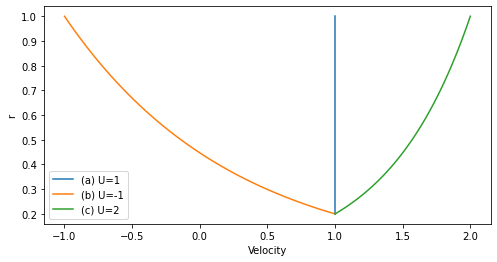

In [3]:
"""
Couette flow between two axially moving cylinders
"""
from dolfin import *

parameters['reorder_dofs_serial'] = False

r0 = 0.2
r1 = 1.0
u0 = Constant(0.1)
u1 = Constant(1)
mesh = IntervalMesh(100, r0, r1)
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

def inner_boundary(x, on_boundary):
    return near(x[0], r0) and on_boundary

def outer_boundary(x, on_boundary):
    return near(x[0], r1) and on_boundary

bc0 = DirichletBC(V, u0, inner_boundary)
bc1 = DirichletBC(V, u1, outer_boundary)

r = Expression("x[0]", degree=1)
F = inner(grad(v), grad(u)) * r * dx == Constant(0) * v * r * dx

u_ = Function(V)

# Compute all three subproblems (3-2) and plot in the same figure
plt.figure(figsize=(8,4))
for u00, u11 in zip([1, 1, 1],[1, -1, 2]):
    u0.assign(u00)
    u1.assign(u11)
    solve(F, u_, bcs=[bc0, bc1])
    plt.plot(u_.vector().get_local(), mesh.coordinates())

plt.legend(["(a) U=1", "(b) U=-1", "(c) U=2"], loc="lower left")
plt.xlabel("Velocity")
plt.ylabel("r")

u_exact = (u1-u0)*ln(r)/ln(r1/r0) + u0 - (u1-u0)*ln(r0)/ln(r1/r0)
u_exact = project(u_exact, V)
print('Error ', errornorm(u_, u_exact, degree_rise=0))
plt.show()


(unsteady-couette-flows)=
## Unsteady Couette flows

Transient behavior can be obtained for Couette type flows, where the velocity of the walls are either

1. Suddenly accelerated to a constant velocity $u_{wall}=U_0$
2. Oscillated as a function of time, i.e., $u_{wall}=f(t)$.

The governing equation for these types of flow is the homogeneous heat equation

$$
  \frac{\partial \boldsymbol{u}}{\partial t} = \nu \nabla^2 \boldsymbol{u}.
$$

We consider only parallel shear flows in Cartesian coordinates, where the velocity vector is
$\boldsymbol{u} = (u(y, t), 0, 0)$ and the equation is reduced to

```{math}
:label: eq:Heat1D
  \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial y^2}.
```

There are many different solutions available for this 1D heat equation, depending on the boundary and initial conditions of the problem. Most solutions make use of the Fourier series, the Fourier integral or Fourier transforms, see, e.g., {cite}`kreyszig`.

### Unsteady flow between two infinite plates

As a first example consider two infinite plates separated by a distance $h$ containing fluid initially at rest at $t=0$. At $t=0$ the velocity of the lower plate at $y=0$ is suddenly accelerated to a velocity of $U_0$ and the fluid above the plate starts to move due to friction and the no-slip boundary condition. The flow will approximate the steady linear Couette solution $U_0(1-y/h)$ as $t \longrightarrow \infty$. Find the velocity between the plates as a function of time and space.

The velocity, $\boldsymbol{u}=(u(y), 0, 0)$, is parallel to the walls and described by the 1D heat equation

$$
\begin{aligned}
  \frac{\partial u}{\partial t} - \nu \frac{\partial ^2 u}{\partial y^2} &= 0, \quad \mathrm{ for }\quad 0 \leq y \leq h \\
  u(y, 0) &= 0, \quad 0 < y < h \\
  u(0, t) &= U_0, \\
  u(h, t) &= 0
\end{aligned}
$$

Through a shift of variables and using the steady Couette solution $v(y, t) = u(y, t) - U_0(1-y/h)$, the problem can be redefined with homogeneous boundary conditions

$$
\begin{aligned}
  \frac{\partial v}{\partial t} - \nu \frac{\partial ^2 v}{\partial y^2} &= 0, \quad \mathrm{ for }\quad 0 \leq y \leq h \\
  v(y, 0) &= -U_0(1-y/h), \quad 0 < y < h \\
  v(0, t) &= 0, \\
  v(h, t) &= 0
\end{aligned}
$$

We can solve this problem easily using separation of variables $v(y, t) = T(t) V(y)$. Inserted into the heat equation we obtain as before

$$
 \frac{\dot{T}}{\nu T} = \frac{V''}{V} = -\lambda^2
$$

and two ordinary differential equations for $T$ and $V$

$$
\begin{aligned}
  T(t) &= e^{-\lambda^2 \nu t}, \\
  V(y) &= A\sin(\lambda y) + B \cos(\lambda y).
\end{aligned}
$$

The boundary conditions give us $B=0$ and $\lambda = \lambda_n = n \pi / h$ for $n=1,2,\ldots$. Using superposition we get the total solution for $v(y, t)$:

$$
  v(y, t) = \sum_{n=1}^{\infty} A_n \sin(\lambda_n y) e^{-\lambda_n^2 \nu t},
$$

where the coefficients are found using the initial condition and orthogonality. That is,  multiply $v(y, 0)$ by $\sin(\lambda_m)$, integrate from $0$ to $h$ and isolate $A_n$:

$$
\begin{aligned}
  A_n &= -\frac{2U_0}{h}\int_0^h \sin(\lambda_n y)(1-y/h) \mathrm{d}y \\
  A_n &= -\frac{2 U_0}{n \pi}
\end{aligned}
$$

The total solution is then

$$
  u(y, t) = U_0(1-y/h) - \frac{2U_0}{\pi}\sum_{n=1}^{\infty} \frac{\sin(\lambda_n y)}{n} e^{-\lambda_n^2 \nu t}.
$$


### Unsteady flow over moving plate

As a second example of flow that is suddenly accelerated by a moving wall, consider a infinite plane normal to the $y$-axis located at $y=0$ and initially at rest at $t=0$. The plane is then suddenly accelerated to a constant velocity $U_0$ in the $x$-direction and remains at this velocity for all $t>0$. Above the plane, for $y>0$, the fluid is initially at rest. Friction and the no-slip boundary condition will make the flow above the plane increase in speed. Far away from the plane the velocity will be zero, i.e., $u(\infty, t)=0$. This means that the velocity will never reach a steady state, and the boundary layer over the plane will continue to grow for all time.

We can find the solution as before using a separation of variables, but first we normalize the velocity

$$
  v(y, t) = \frac{u-U_0}{U_0},
$$

such that the boundary condition at $y=0$ becomes homogeneous, i.e., $v(0, t)=0$ for $t>0$. The PDE for $v$ is still {eq}`eq:Heat1D`.

Start by separating variables

$$
  v(y, t) = T(t)V(y).
$$

Inserted into {eq}`eq:Heat1D` we get

$$
  \frac{\dot{T}}{\nu T} = \frac{V''}{V} = K,
$$

where $K$ is a constant. To obtain physically realistic solutions, the constant needs to be negative. This can be understood looking first at the transient part:

$$
  \dot{T} = K \nu T,
$$

with solution

$$
  T(t) = e^{K \nu t}.
$$

If $K$ is positive, then the velocity will grow without bounds and without energy being added to the system. For the second equation we have

$$
  V'' - K V = 0.
$$

If $K$ is positive, then the solution is

$$
  V(y) = A \sinh(\sqrt{K} y) + B \cosh (\sqrt{K} y).
$$

The boundary condition $V(0)=0$ requires $B=0$. The remaining term $A\sinh (\sqrt{K} y)$ grows without bounds as $y \longrightarrow \infty$, which is not in agreement with $v(\infty, t)=-1$ and we have to assume that $K$ is a negative constant that we can write as $K=-\lambda^2$. The solutions to the separated ordinary differential equations become

$$
\begin{aligned}
  T(t) &= e^{-\lambda^2 \nu t}, \\
  V(y) &= A \sin(\lambda y) + B \cos(\lambda y).
\end{aligned}
$$

The constants need to be found using boundary and initial conditions. The boundary condition $V(0)=0$ leads to $B=0$ and as such one solution reads

$$
  v(y, t) = A \sin (\lambda y) e^{-\lambda^2 \nu t}.
$$

To satisfy the initial condition we need to use more than one solution and through the superposition principle we can simply add solutions. A periodic Fourier series for $v$ reads

$$
  v(y, t) = \sum_{k=1}^{\infty} A_k \sin (\lambda_k y) e^{-\lambda_k^2 \nu t},
$$

where $A_k$ are constants, $\lambda_k = k \pi / L$ and $L$ is the length of the periodic domain.

However, our domain is not periodic and it is unbounded for $y\longrightarrow \infty$. It turns out that for infinite domains and non-periodic solution, it is advantageous to work with Fourier integrals instead. A Fourier integral for our problem reads

$$
  v(y, t) = \int_{0}^{\infty} A(\lambda) \sin (\lambda y) e^{-\lambda^2 \nu t} d\lambda.
$$

```{figure} ../images/Heaviside.png
---
height: 200px
width: 300px
name: Heaviside
---
The Heaviside function.
```

and the "constant" $A(\lambda)$ is a continuous function of $\lambda$. Since $v$ only contains sinuses it is an odd function. As such, even though we are only interested in the domain $y > 0$ we can define an initial condition for $v(y, 0)$ over the entire $-\infty<y<\infty$ as an odd function

$$
  v(y, 0) = 1-2\boldsymbol{H}(y) = \int_{0}^{\infty} A(\lambda) \sin (\lambda y) d\lambda, \, \mathrm{for } -\infty < y < \infty,
$$

where $\boldsymbol{H(y)}$ is the Heaviside function.

This way $v(y, 0) = 1$ for $y<0$, $v(y, 0)=-1$ for $y>0$ and by symmetry $v(0, 0)=0$. Through orthogonality and the initial condition we can find $A(\lambda)$ as (see {cite}`kreyszig`)

$$
 A(\lambda) = -\frac{2}{\pi}\int_{0}^{\infty} \sin(\lambda y') dy' .
$$

Inserted into the total solution we get

$$
  v(y, t) = -\frac{2}{\pi} \int_{0}^{\infty} \int_{0}^{\infty} \sin(\lambda y') dy' \sin (\lambda y) e^{-\lambda^2 \nu t} d\lambda,
$$

which can be rewritten by changing the order of integration as

$$
  v(y, t) = -\frac{2}{\pi} \int_{0}^{\infty} \int_{0}^{\infty} \sin(\lambda y') \sin (\lambda y) e^{-\lambda^2 \nu t} d\lambda dy'.
$$

The inner integral can be transformed using $\sin(\lambda y)\sin(\lambda y') = 0.5 (\cos \lambda(y-y') - \cos \lambda(y+y'))$

$$
  v(y, t) = -\frac{2}{\pi} \int_{0}^{\infty} \int_{0}^{\infty}  e^{-\lambda^2 \nu t} \frac{1}{2} \left(\cos \lambda(y-y') - \cos \lambda(y+y') \right) d\lambda dy'.
$$

The inner integrals can then be computed exactly since

$$
  \int_{0}^{\infty}  e^{-\lambda^2 \nu t} \cos \lambda(y-y') \mathrm{d} \lambda = \sqrt{\frac{\pi}{4 \nu t}} e^{-\left(\frac{y-y'}{2 \sqrt{\nu t}}\right)^2},
$$

and

$$
  \int_{0}^{\infty}  e^{-\lambda^2 \nu t} \cos \lambda(y+y') \mathrm{d} \lambda = \sqrt{\frac{\pi}{4 \nu t}} e^{-\left(\frac{y+y'}{2 \sqrt{\nu t}}\right)^2}.
$$

The solution now reads

$$
  v(y, t) = -\sqrt{\frac{1}{4 \pi \nu t}} \int_{0}^{\infty} \left( e^{-\left(\frac{y-y'}{2 \sqrt{\nu t}}\right)^2} - e^{-\left(\frac{y+y'}{2 \sqrt{\nu t}}\right)^2} \right)  dy'.
$$

Using integration by substitution, the integrals can be reorganized into error functions

$$
  \mathrm{erf}(z) = \frac{2}{\sqrt{\pi}} \int_0^{z} e^{-u^2} \mathrm{d}u,
$$

if we simply use a change of variables

$$
\begin{aligned}
  u &= \frac{y-y'}{2 \sqrt{\nu t}}, \quad \frac{\mathrm{d}u}{\mathrm{d} y'} = -\frac{1}{2\sqrt{\nu t}} \\
  u' &= \frac{y+y'}{2 \sqrt{\nu t}}, \quad \frac{\mathrm{d}u}{\mathrm{d} y'} = \frac{1}{2\sqrt{\nu t}}
\end{aligned}
$$

The integrals become

$$
\begin{aligned}
\int_{0}^{\infty} e^{-\left(\frac{y-y'}{2 \sqrt{\nu t}}\right)^2}   dy' &= -2\sqrt{\nu t} \int_{\frac{y}{2\sqrt{\nu t}}}^{-\infty} e^{-u^2} \mathrm{d}u,\\
    &= -\sqrt{\nu t \pi}\left(1+ \mathrm{erf}\left(\frac{y}{2\sqrt{\nu t}}\right) \right)
\end{aligned}
$$

and

$$
\begin{aligned}
\int_{0}^{\infty} e^{-\left(\frac{y+y'}{2 \sqrt{\nu t}}\right)^2}   dy' &= 2\sqrt{\nu t} \int_{\frac{y}{2\sqrt{\nu t}}}^{\infty} e^{-u^2} \mathrm{d}u,\\
    &= \sqrt{\nu t \pi}\left(1- \mathrm{erf}\left(\frac{y}{2\sqrt{\nu t}}\right) \right).
\end{aligned}
$$

Putting it all together we finally obtain

$$
\begin{aligned}
  v(y, t) &= -\sqrt{\frac{1}{4 \pi \nu t}} \left(-\sqrt{\nu t \pi} \right) (-2) \mathrm{erf}\left(\frac{y}{2\sqrt{\nu t}} \right), \\
  &= -\mathrm{erf}\left(\frac{y}{2\sqrt{\nu t}} \right).
\end{aligned}
$$

The original unnormalized velocity becomes

```{math}
:label: eq:Stokesfirst
  u(y, t) = U_0\left(1-\mathrm{erf} \left(\frac{y}{2\sqrt{\nu t}} \right) \right),
```

in agreement with Eq. 3-107 in {cite}`white06`. Profiles for the velocity above the plane is computed below, where the first plot includes the unphysical (mirror) domain.

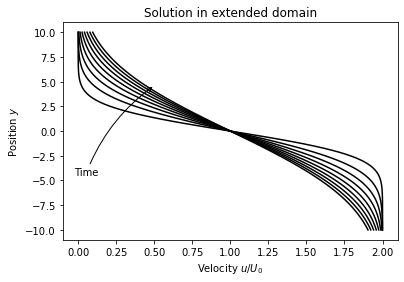

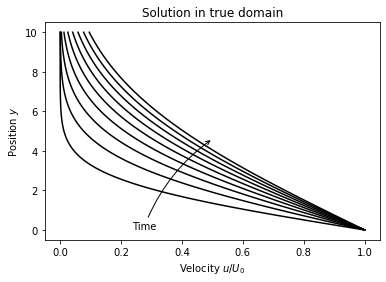

In [5]:
import numpy as np
from scipy.special import erf

nu = 0.01
U0 = 1.
for y0, title in zip((-10, 0), ('Solution in extended domain', 'Solution in true domain')):
    y = np.linspace(y0, 10, 100)
    plt.figure(figsize=(6, 4))
    for i in range(1, 10):
        t = i * 200.
        u = U0*(1-erf(y/2/sqrt(nu*t)))
        plt.plot(u, y, "k")

    plt.annotate(r'Time', xy=(0.5, 4.6),
                 xytext=(-80, -90), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.15"))
    plt.xlabel("Velocity " + r"$u/U_0$")
    plt.ylabel("Position " + "$y$")
    plt.title(title)
plt.show()

### Fluid oscillation above an infinite plate

An infinite plate oscillates with a velocity $u(0, t) = U_0 \cos (\omega t)$, which is the boundary condition to the fluid flow set in motion above the plate. We look for a "steady state" solution $\boldsymbol{u} = (u(y), 0, 0)$, meaning that we look for a solution independent of initial conditions. This problem is also referred to as Stokes second problem.

Since the plate oscillates with frequency $\cos (\omega t)$ a justified guessed solution is

```{math}
  u(y, t) = f(y) e^{i \omega t} .
```

Inserted into the unsteady 1D heat equation we obtain

$$
\begin{aligned}
  f i \omega \cancel{e^{i \omega t}} - \nu f^{''} \cancel{e^{i \omega t}} &= 0, \\
  f^{''} - \frac{i \omega}{\nu}f &= 0
\end{aligned}
$$

A general solution to this problem is

$$
  f(y) = Ae^{-\sqrt{\frac{i\omega}{\nu}}y} + Be^{\sqrt{\frac{i\omega}{\nu}}y},
$$

where only the first leads to physically realistic real solutions for $y\longrightarrow \infty$, such that $B=0$. The boundary condition at $y=0$ leads to

$$
  u(0, t) = f(0)e^{i \omega t} = A e^{i \omega t},
$$

where the real part then requires $A=U_0$ and as such

$$
 u(y, t) = U_0  e^{ -\sqrt{\frac{i\omega}{\nu}} y + i \omega t}
$$


## Suggested assignments Couette

(couette-problems-white)=
### Couette problems from White:

Problems 3-1, 3-2, 3-3, 3-4 and 3-5.

(additional-couette-problem)=
### Additional Couette problems:

(homogeneous-heat-equation)=
#### Homogeneous heat equation with inhomogeneous boundary conditions

Consider the homogeneous heat equation with inhomogeneous boundary conditions

```{math}
:label: eq:heathominhom
\begin{aligned}
  \frac{\partial u}{\partial t} - \nu \frac{\partial ^2 u}{\partial y^2} &= 0, \quad \mathrm{ for }\quad 0 \leq y \leq L \\
  u(y, 0) &= \phi(y), \\
  u(0, t) &= g, \\
  u(L, t) &= h
\end{aligned}
```

where $g$ and $h$ are constants. Find the general solution $u(y, t)$. Hint: use a function $\boldsymbol{U}(y) =
1/L[(L-y)g + y h]$ and find the solution of $v(y, t) = u(y, t) - \boldsymbol{U}(y)$. The equation for $v(y, t)$ is
the same as for $u(y, t)$, but now with homogeneous boundary conditions.

Optional (difficult, and not part of syllabus), find the general solution if $g$ and $h$ are functions of time. Two hints to the optional
assignment are

(problem-6-hint-1)=
##### Hint 1
Use a function $\boldsymbol{U}(y, t) = 1/L[(L-y)g(t) + y h(t)]$ and find the solution of $v(y, t) = u(y,t)-\boldsymbol{U}(y,t)$. The equation for $v(y, t)$ should be obtained as an inhomogeneous heat equation with homogeneous boundary conditions.

(problem-6-hint-2)=
##### Hint 2 
Use Duhamel's principle to solve the inhomogeneous heat equation. Duhamel's principle states that the solution to the inhomogeneous heat equation can be found through solving just the homogeneous part. An inhomogeneous heat equation for $v(y, t)$ reads

```{math}
:label: eq:Heat1DInhomo
\begin{aligned}
  \frac{\partial v}{\partial t} - \nu \frac{\partial ^2 v}{\partial y^2} &= f(y, t), \quad \mathrm{ for }\quad 0 \leq y \leq L    \\
\notag  v(y, 0) &= \overline{\phi}(y), \\
\notag  v(0, t) &= v(L, t) = 0,
\end{aligned}
```

We can solve instead the homogeneous part

```{math}
:label: eq:Heat1DHomo
\begin{aligned}
  \frac{\partial v^h}{\partial t} - \nu \frac{\partial ^2 v^h}{\partial y^2} &= 0, \quad \mathrm{ for }\quad 0 \leq y \leq L    \\
\notag  v^h(y, 0) &= \overline{\phi}(y), \\
\notag  v^h(0, t) &= v^h(L, t) =  0,
\end{aligned}
```

using for example a separation of variables $v^h(y,t)=S(t)V(y)$. The solution will evolve from the initial condition $\overline{\phi}$ and we thus expect the solution in a small increment of time to be expressed as $v^h(y, t) = S(t)\overline{\phi}(y)$. Duhamel's principle then states that the solution to the inhomogeneous problem can be computed as

$$
  v(y, t) = v^h(y, t) + \int_0^t S(t-s)f(y, s)\mathrm{d}s,
$$

where $S(t-s)f(y, s)$ is the homogeneous solution we found earlier, but computed from the initial condition $f(y, s)$ instead of $\overline{\phi}$. One may think of $\int_0^t S(t-s)f(y, s)\mathrm{d}s$ as a superposition in time. Initialize using $f(y, s)$ and then move the solution an infinitesimal time forward using the homogeneous solution. By linearity, or superposition in time, one may add up, or integrate, the solution in time.<br>

Duhamel's principle can be justified by computation. Insert for the inhomogeneous solution in the inhomogeneous equation

$$
  \frac{\partial v}{\partial t} - \nu \frac{\partial^2 v}{\partial y^2} = \cancel{\frac{\partial v^h}{\partial t} - \nu \frac{\partial^2 v^h}{\partial y^2}} + \left( \frac{\partial }{\partial t} - \nu \frac{\partial^2 }{\partial y^2}  \right) \left( \int_0^t S(t-s)f(y, s)\mathrm{d}s\right)
$$

Use Leibniz rule for differentiation under the integral sign on the last part

$$
\begin{aligned}
  \frac{\partial v}{\partial t} - \nu \frac{\partial^2 v}{\partial y^2} &= S(t-t)f(y, t) + \int_0^t \left(\frac{\partial }{\partial t} - \nu \frac{\partial^2 }{\partial y^2}  \right) S(t-s)f(y, s)\mathrm{d}s, \\
 &= S(0)f(y, t) = f(y, t).
\end{aligned}
$$

The integral is zero since the integrand $S(t-s)f(y, s)$ is known to be a solution of the homogeneous heat equation.

(computer-assignments-couette)=
### Computer assignments Couette

(rotating-cylinders)=
#### Rotating cylinders

Validate the analytical results (3-22) and (3-23) in Chapter 3-2.3 of {cite}`white06`, for flow between rotating concentric cylinders. Can you reproduce Eq.~(3-23)?

(implement-heat-equation)=
#### Implement Eq. {eq}`eq:heathominhom`

Consider {eq}`eq:heathominhom` with suitable $g$ and $h$ and compare the analytical solution from the written assignment with a numerical implementation.


```{bibliography} ../../references.bib
:filter: docname in docnames
```